# Data Analysis for project Olist
GitHub location: https://github.com/LarsTinnefeld/Olist-order-profile-analysis

Tasks:

1) EDA
- Units per order
- Lines per order
- Units per order line
- Pareto curve units
- Pareto curve order lines
- XYZ profile

3) 


Structure of this notebook:

- Data import and preparation
- Exploratory data analysis

---
## Data Preparation
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

### Importing datasets
This dataset stems from the previous data analysis (olist_ecom_analysis)

In [2]:
df_orders_consolidated = pd.read_csv('df_orders_consolidated.csv')

In [3]:
df_orders_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102422 entries, 0 to 102421
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102422 non-null  int64  
 1   order_id                       102422 non-null  object 
 2   customer_id                    102422 non-null  object 
 3   order_status                   102422 non-null  object 
 4   order_purchase_timestamp       102422 non-null  object 
 5   order_approved_at              102408 non-null  object 
 6   order_delivered_carrier_date   101395 non-null  object 
 7   order_delivered_customer_date  102422 non-null  object 
 8   order_estimated_delivery_date  102422 non-null  object 
 9   date_ordinal                   102422 non-null  int64  
 10  shipping_time_delta            102422 non-null  int64  
 11  shipping_duration              102422 non-null  int64  
 12  estimated_duration            

---
## Exploratory data analysis

### Order composition

In [4]:
df_order_class_comp = df_orders_consolidated.groupby([
    'order_id',
    'product_category_name'
    ]).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        }).reset_index()

In [5]:
df_order_class_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98017 entries, 0 to 98016
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  98017 non-null  object 
 1   product_category_name     98017 non-null  object 
 2   product_id                98017 non-null  int64  
 3   qty                       98017 non-null  int64  
 4   price                     98017 non-null  float64
 5   order_line_cube_in_ltr    98017 non-null  float64
 6   product_weight_g          98017 non-null  float64
 7   estimated_duration        98017 non-null  int64  
 8   shipping_duration         98017 non-null  int64  
 9   shipping_time_delta       98017 non-null  int64  
 10  order_purchase_timestamp  98017 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 8.2+ MB


How many units are in an order? => Units per order

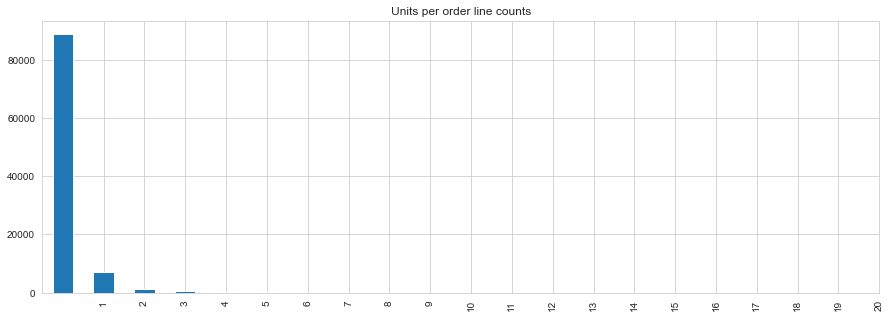

In [6]:
upl_range = np.arange(1, df_order_class_comp['qty'].max(), 1)
(df_order_class_comp['qty'].value_counts()).plot(
                                            kind='bar',
                                            figsize = (15, 5),
                                            xticks = upl_range,
                                            title = 'Units per order line counts'
                                            );

In [10]:
df_upo_lpo = df_orders_consolidated.groupby('order_id').agg({'qty': 'sum', 'product_id': 'count'}).reset_index()
df_upo_lpo.rename(columns = {'qty': 'units', 'product_id': 'lines'}, inplace = True)

In [11]:
df_upo_lpo

,order_id,units,lines
0,00010242fe8c5a6d1ba2dd792cb16214,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,1
2,000229ec398224ef6ca0657da4fc703e,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1
...,...,...,...
98659,fffc94f6ce00a00581880bf54a75a037,1,1
98660,fffcd46ef2263f404302a634eb57f7eb,1,1
98661,fffce4705a9662cd70adb13d4a31832d,1,1
98662,fffe18544ffabc95dfada21779c9644f,1,1


<AxesSubplot:xlabel='lines'>

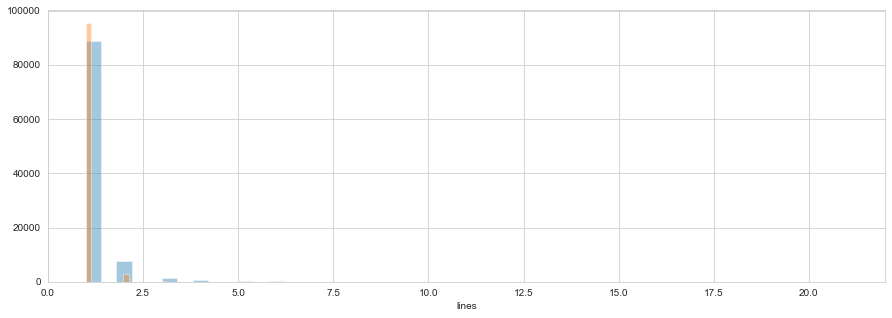

In [20]:
x_range = np.arange(1, df_upo_lpo['units'].max(), 1)
plt.figure(figsize = (15, 5))
sns.distplot(df_upo_lpo['units'], kde = False)
sns.distplot(df_upo_lpo['lines'], kde = False)